In [31]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip -O training.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip -O training_truth.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_Data.zip -O testing.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_GroundTruth.zip -O testing_truth.zip

--2024-11-13 23:21:13--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.225.201, 54.231.130.177, 52.217.232.97, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.225.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242932767 (232M) [application/zip]
Saving to: ‘testing.zip’

testing.zip         100%[===================>] 231.68M  13.9MB/s    in 18s     

2024-11-13 23:21:33 (12.6 MB/s) - ‘testing.zip’ saved [242932767/242932767]

--2024-11-13 23:21:33--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.29.43, 52.217.67.60, 3.5.29.209, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.29.43|:443...

In [32]:
!unzip -qq -n training.zip
!unzip -qq -n training_truth.zip
!unzip -qq -n testing.zip
!unzip -qq -n testing_truth.zip

unzip:  cannot find or open training_truth.zip, training_truth.zip.zip or training_truth.zip.ZIP.


In [36]:
import random
import gc

import numpy
import tensorflow as tf
from tensorflow import data
from keras import layers, utils, losses, metrics
from matplotlib import pyplot
import seaborn
import pandas
from tqdm import tqdm

# Check for GPU
print(tf.config.list_physical_devices("GPU"))

# For seed sync
random.seed()

RAW_WIDTH = 512
RAW_HEIGHT = 512
RAW_SIZE = (RAW_WIDTH, RAW_HEIGHT)
WIDTH = 256
HEIGHT = 256
SIZE = (WIDTH, HEIGHT)
TRAINING_DIR = "/content/ISBI2016_ISIC_Part1_Training_Data"
TRAINING_TRUTH_DIR = "/content/ISBI2016_ISIC_Part1_Training_GroundTruth"
BATCH_SIZE = 200
SAVED_FILE = f"p1_weights_{WIDTH}_{HEIGHT}.h5"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
seed = random.randint(0, 2**32 - 1)

input_images = utils.image_dataset_from_directory(
    TRAINING_DIR,
    labels=None,
    label_mode=None,
    image_size=RAW_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    interpolation="bilinear",
    seed=seed
)

input_images = input_images.cache()

label_images = utils.image_dataset_from_directory(
    TRAINING_TRUTH_DIR,
    labels=None,
    label_mode=None,
    image_size=RAW_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    interpolation="nearest",
    seed=seed
)

label_images = label_images.cache()

Found 900 files.
Found 900 files.


In [10]:
class Preprocessing():
    def __init__(self):
        seed = random.randint(0, 2**32 - 1)
        self.scale = layers.Rescaling(scale=1./255)
        self.rotate_x = layers.RandomRotation(
            factor=0.2, fill_mode="constant", interpolation="bilinear", seed=seed)
        self.rotate_y = layers.RandomRotation(
            factor=0.2, fill_mode="constant", interpolation="nearest", seed=seed)
        self.crop_x = layers.RandomCrop(height=HEIGHT, width=WIDTH, seed=seed)
        self.crop_y = layers.RandomCrop(height=HEIGHT, width=WIDTH, seed=seed)
        self.brightness = layers.RandomBrightness(
            factor=0.2, value_range=(0, 1))
        self.contrast = layers.RandomContrast(factor=0.2)
        self.flip_x = layers.RandomFlip(seed=seed)
        self.flip_y = layers.RandomFlip(seed=seed)

    def __call__(self, inputs, labels):
        index = numpy.arange(inputs.shape[0] * 2)
        numpy.random.shuffle(index)
        # Inputs
        x = self.scale(inputs)
        x = self.rotate_x(x)
        x = self.crop_x(x)
        x = tf.repeat(x, repeats=2, axis=0)
        x = self.brightness(x)
        x = self.contrast(x)
        x = self.flip_x(x)
        x = tf.convert_to_tensor(x.numpy()[index])
        # Labels
        y = self.scale(labels)
        y = self.rotate_y(y)
        y = self.crop_y(y)
        y = tf.repeat(y, repeats=2, axis=0)
        y = self.flip_y(y)
        y = tf.convert_to_tensor(y.numpy()[index], dtype="int8")
        return (x, y)


preprocessing = Preprocessing()

In [14]:
from model import UNet

model = UNet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses.BinaryFocalCrossentropy(
        apply_class_balancing=False,
        alpha=0.25,
        gamma=2.0
    ),
    metrics=[
        "BinaryAccuracy",
        "BinaryIoU"
    ]
)
model(layers.Input((WIDTH, HEIGHT, 3)))
iou_history = []

<KerasTensor shape=(None, 256, 256, 1), dtype=float32, sparse=False, name=keras_tensor_37>

In [16]:
EPOCH = 25

for epoch in range(EPOCH):
    print(f"=== Epoch {epoch} ===")
    zipped = tf.data.Dataset.zip((input_images, label_images))
    for (inputs, labels) in tqdm(zipped):
        inputs, labels = preprocessing(inputs, labels)
        history = model.fit(inputs, labels, verbose=0)
        iou_history.append(history.history["BinaryIoU"])
    gc.collect()

=== Epoch 0 ===


100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


=== Epoch 1 ===


100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


=== Epoch 2 ===


100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


=== Epoch 3 ===


100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


=== Epoch 4 ===


100%|██████████| 18/18 [00:08<00:00,  2.00it/s]


=== Epoch 5 ===


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


=== Epoch 6 ===


100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


=== Epoch 7 ===


100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


=== Epoch 8 ===


100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


=== Epoch 9 ===


100%|██████████| 18/18 [00:08<00:00,  2.00it/s]


=== Epoch 10 ===


100%|██████████| 18/18 [00:08<00:00,  2.00it/s]


=== Epoch 11 ===


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


=== Epoch 12 ===


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


=== Epoch 13 ===


100%|██████████| 18/18 [00:08<00:00,  2.00it/s]


=== Epoch 14 ===


100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


=== Epoch 15 ===


100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


=== Epoch 16 ===


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


=== Epoch 17 ===


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


=== Epoch 18 ===


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


=== Epoch 19 ===


100%|██████████| 18/18 [00:08<00:00,  2.00it/s]


=== Epoch 20 ===


100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


=== Epoch 21 ===


100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


=== Epoch 22 ===


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


=== Epoch 23 ===


100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


=== Epoch 24 ===


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


<Axes: >

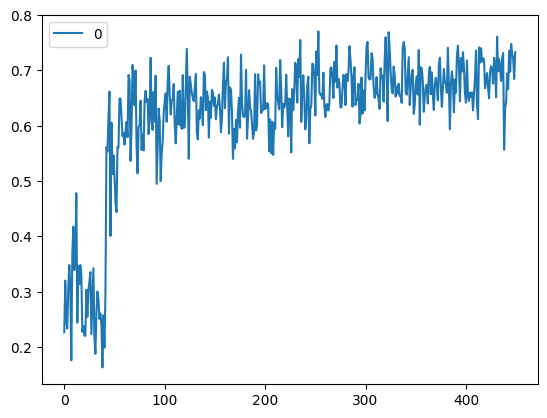

In [26]:
iou_history_pd = pandas.DataFrame(iou_history)
seaborn.lineplot(iou_history_pd)

In [34]:
TRAINING_DIR = "/content/ISBI2016_ISIC_Part1_Training_Data"
TRAINING_TRUTH_DIR = "/content/ISBI2016_ISIC_Part1_Training_GroundTruth"
BATCH_SIZE = 1
SAVED_FILE = f"saved/v1/weights_{WIDTH}_{HEIGHT}.h5"

In [35]:
seed = 100

input_images = utils.image_dataset_from_directory(
    TRAINING_DIR,
    labels=None,
    label_mode=None,
    image_size=SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=False,
    seed=seed
)

input_images = input_images.cache()

label_images = utils.image_dataset_from_directory(
    TRAINING_TRUTH_DIR,
    labels=None,
    label_mode=None,
    image_size=SIZE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=False,
    seed=seed
)

label_images = label_images.cache()

Found 900 files.
Found 900 files.


In [37]:
metric = metrics.BinaryIoU()
loss_list = []
for (inputs, labels) in tqdm(data.Dataset.zip((input_images, label_images))):
    labels = tf.cast(labels > 0.5, dtype="int8")
    outputs = model(inputs / 255)
    loss_value = metric(labels, outputs).numpy()
    loss_list.append(loss_value)
total_loss = numpy.average(loss_list)
print(f"Mean Itersect-over-Union: {total_loss}")

100%|██████████| 900/900 [00:53<00:00, 16.76it/s]

Mean Itersect-over-Union: 0.7138893008232117
